In [22]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_info:str

def play_node(state:State):
    print('play_node called')
    return {'graph_info':str(State['graph_info'])+'play_node'}

def cricket_node(state:State):
    print('play_node called')
    return {'graph_info':str(State['graph_info'])+'cricket_node'}

def football_node(state:State):
    print('play_node called')
    return {'graph_info':str(State['graph_info'])+'football_node'}



In [23]:
from typing import Literal
import random

def random_play(state:State)->Literal['cricket_node','football_node']:
    graph_info = state['graph_info']
    if random.random()>0.5:
        return 'cricket_node'
    else:
        return 'football_node'


In [24]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph = StateGraph(State)

graph.add_node("play_node",play_node)
graph.add_node("cricket_node",cricket_node)
graph.add_node("football_node",football_node)

graph.add_edge(START,'play_node')
graph.add_conditional_edges('play_node',random_play)
graph.add_edge('cricket_node',END)
graph.add_edge('football_node',END)

graph_builder = graph.compile()

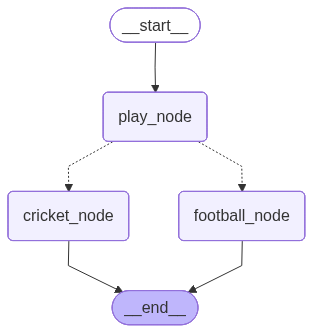

In [25]:
graph_builder

In [26]:
graph_builder.invoke({"graph_info":"Hello"})

play_node called
play_node called


{'graph_info': "__main__.State['graph_info']football_node"}